<font size=6 color='purple'>**Counts plots**</font>

*Notes:* Initialization cells must be run before plotting, since they define colors and snapshot numbers


<font color='red' weight='bold'>**NOTE: cells must be run in order to reproduce the right plot under the right set of data. This is done so that plots can be remade quickly without needing to rerun data**</font>

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [19]:
plt.rcParams.update({'font.size':20})

# Initialization

In [3]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [4]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


## Function defs

In [5]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [6]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass
# need to use different redshift cuts cause 54 dne, and 53+55 hydro dne

# function to get the halo counts 
def get_counts(sim, phys, size, groupCut=False, median=False, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, medians, quarts, unpairs, pairs = [], [], [], [], []
       
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpaired = pair_data["unpaired"][phys]
            unpaired_stells = np.array(unpaired["Sub1 Stellar Mass"])
            unpaired_prims = get_primmask(unpaired_stells, size)
            unpaired_group = get_groupmask(np.array(unpaired["Group Mass"]), size)                
            unpaired_median = np.array( unpaired['Realization'] )==-1
            
            paired = pair_data["pairs"][phys]
            paired_stells = np.array(paired["Sub1 Stellar Mass"])
            paired_prims = get_primmask(paired_stells, size)
            paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
            paired_median = np.array( paired['Realization'] )==-1

                
            if median:
                if groupCut:
                    unpaired_mask = unpaired_prims & unpaired_group & unpaired_median
                    paired_mask = paired_prims & paired_group & paired_median
                
                else: 
                    unpaired_mask = unpaired_prims & unpaired_median
                    paired_mask = paired_prims & paired_median
                
                num_unpaired = np.count_nonzero(unpaired_mask)
                num_paired = np.count_nonzero(paired_mask)
                num_prims = num_unpaired + num_paired             
                quarts_z = [0,0]

                
            else: 
                unpaired_per_real = []
                paired_per_real = []
                total_per_real = []
                
                realizations = np.unique( np.array(paired['Realization']) )
                
                for real in realizations:
                    unpaired_real = np.array( unpaired['Realization'] ) == real
                    paired_real = np.array( paired['Realization'] ) == real
                    
                    if groupCut:
                        unpaired_mask = unpaired_prims & unpaired_group & unpaired_real
                        paired_mask = paired_prims & paired_group & paired_real
                        
                    else:
                        unpaired_mask = unpaired_prims & unpaired_real
                        paired_mask = paired_prims & paired_real
                        
                    unpaired_per_real.append( np.count_nonzero(unpaired_mask) )
                    paired_per_real.append( np.count_nonzero(paired_mask) )
                    total_per_real.append( np.count_nonzero(unpaired_mask)+np.count_nonzero(paired_mask) )
                    
                num_unpaired = np.median(unpaired_per_real)
                num_paired = np.median(paired_per_real)
                num_prims = np.median(total_per_real)
                quarts_z = np.percentile( total_per_real,[16,84] ) 
                
            redshifts.append(redshift)
            unpairs.append( num_unpaired )
            pairs.append( num_paired )
            medians.append( num_prims )
            quarts.append( quarts_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {"z":np.array(redshifts),
                        "medians": np.array(medians),
                        "quartiles": np.array(quarts),
                        "unpaired": np.array(unpairs),
                        "paired": np.array(pairs)}
    
    return count_dictionary
        
def get_counts_simstell(sim, size, groupCut=False, errorprint=False, redshiftcutoff=True):
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, medians, quarts, unpairs, pairs = [], [], [], [], []  
    
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpaired = pair_data["unpaired"]["hydro"]
            unpaired_stells = np.array(unpaired["Sub1 Stellar Mass"])
            unpaired_prims = get_primmask(unpaired_stells, size)
            unpaired_group = get_groupmask(np.array(unpaired["Group Mass"]), size)                
            
            paired = pair_data["paired"]["hydro"]
            paired_stells = np.array(paired["Sub1 Stellar Mass"])
            paired_prims = get_primmask(paired_stells, size)
            paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
                
            if groupCut:
                unpaired_mask = unpaired_prims & unpaired_group 
                paired_mask = paired_prims & paired_group 

            else: 
                unpaired_mask = unpaired_prims 
                paired_mask = paired_prims

            num_unpaired = np.count_nonzero(unpaired_mask)
            num_paired = np.count_nonzero(paired_mask)
            num_prims = num_unpaired + num_paired             
            quarts_z = [0,0]
                
            redshifts.append(redshift)
            unpairs.append( num_unpaired )
            pairs.append( num_paired )
            medians.append( num_prims )
            quarts.append( quarts_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {"z":np.array(redshifts),
                        "medians": np.array(medians),
                        "quartiles": np.array(quarts),
                        "unpaired": np.array(unpairs),
                        "paired": np.array(pairs)}
    
    return count_dictionary
        

# Counts

get_counts(sim, phys, size, groupCut=False, median=False, errorprint=False, redshiftcutoff=True)

get_counts_simstell(sim, size, groupCut=False, errorprint=False, redshiftcutoff=True)

## Dwarfs

In [20]:
illd = get_counts("Illustris", "dark", "dwarf")
illh = get_counts("Illustris", "hydro", "dwarf")
print("done with Illustris")


tngd = get_counts("TNG", "dark", "dwarf")
tngh = get_counts("TNG", "hydro", "dwarf")
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "dwarf")
print("done with ill")
tngsim = get_counts_simstell("TNG", "dwarf")
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


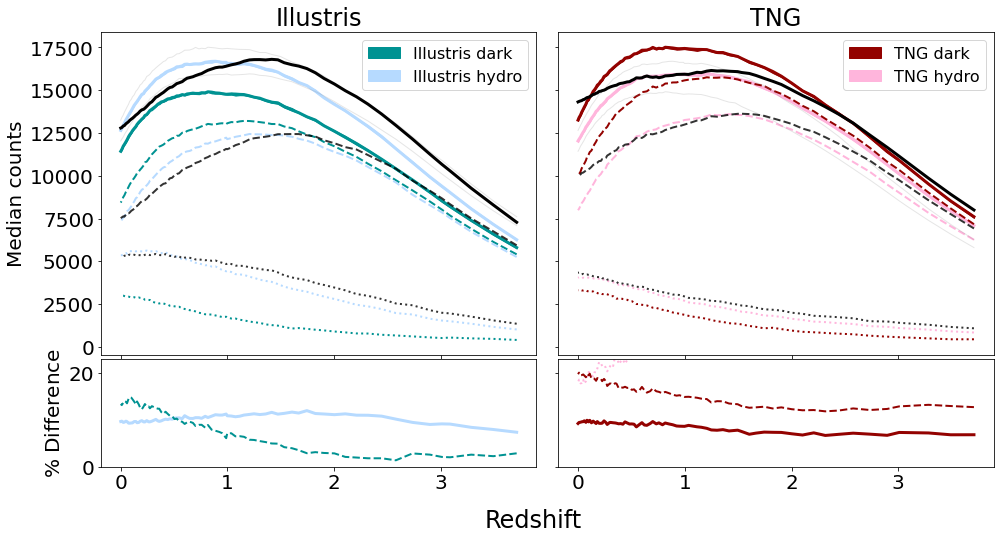

In [21]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/no_groupcut_d.png",bbox_inches='tight',facecolor="white")
plt.show()


In [22]:
illd = get_counts("Illustris", "dark", "dwarf",groupCut=True)
illh = get_counts("Illustris", "hydro", "dwarf",groupCut=True)
print("done with Illustris")


tngd = get_counts("TNG", "dark", "dwarf",groupCut=True)
tngh = get_counts("TNG", "hydro", "dwarf",groupCut=True)
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "dwarf",groupCut=True)
print("done with ill")
tngsim = get_counts_simstell("TNG", "dwarf",groupCut=True)
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


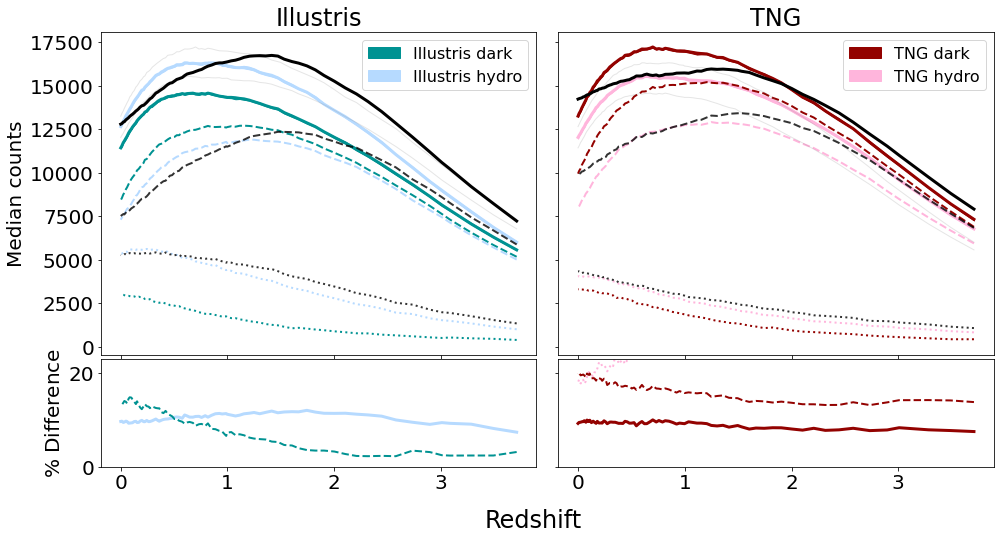

In [23]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/groupcut_d.png",bbox_inches='tight',facecolor="white")
plt.show()


## Massive

In [24]:
illd = get_counts("Illustris", "dark", "massive")
illh = get_counts("Illustris", "hydro", "massive")
print("done with Illustris")


tngd = get_counts("TNG", "dark", "massive")
tngh = get_counts("TNG", "hydro", "massive")
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "massive")
print("done with ill")
tngsim = get_counts_simstell("TNG", "massive")
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


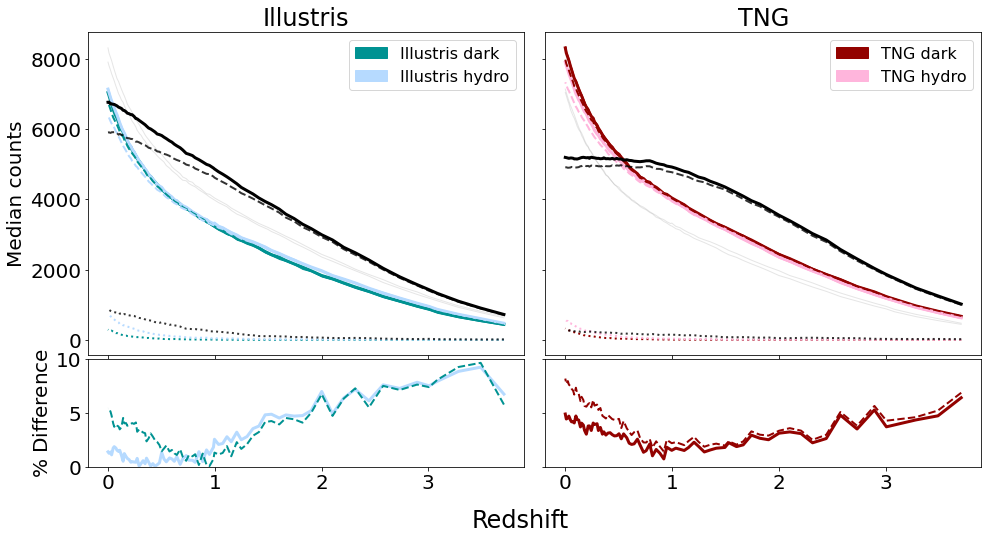

In [25]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,10)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/no_groupcut_m.png",bbox_inches='tight',facecolor="white")
plt.show()


In [26]:
illd = get_counts("Illustris", "dark", "massive",groupCut=True)
illh = get_counts("Illustris", "hydro", "massive",groupCut=True)
print("done with Illustris")


tngd = get_counts("TNG", "dark", "massive",groupCut=True)
tngh = get_counts("TNG", "hydro", "massive",groupCut=True)
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "massive",groupCut=True)
print("done with ill")
tngsim = get_counts_simstell("TNG", "massive",groupCut=True)
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


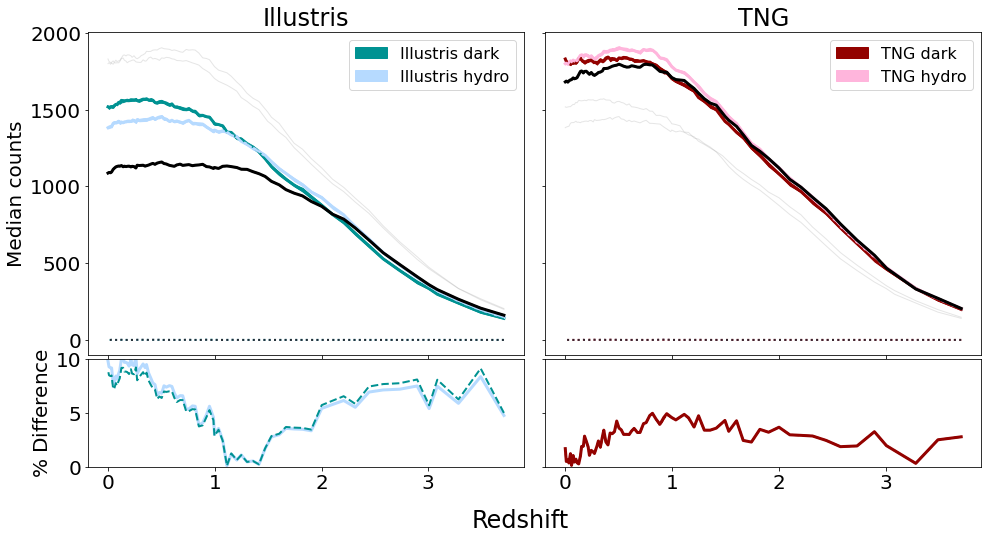

In [27]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,10)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/groupcut_m.png",bbox_inches='tight',facecolor="white")
plt.show()


# Scratch

In [15]:
illgr = get_counts("Illustris", "dark", "massive",median=True, groupCut=True)
illnogr = get_counts("Illustris", "dark", "massive",median=True, groupCut=False)


In [16]:
illgr['medians']-illnogr['medians']


array([ -183,  -228,  -292,  -353,  -390,  -428,  -492,  -550,  -567,
        -618,  -633,  -686,  -739,  -806,  -888,  -938, -1007, -1060,
       -1094, -1148, -1212, -1275, -1310, -1359, -1396, -1475, -1521,
       -1551, -1610, -1666, -1685, -1732, -1770, -1824, -1889, -1941,
       -1966, -2043, -2100, -2160, -2214, -2269, -2325, -2367, -2413,
       -2486, -2548, -2606, -2669, -2725, -2794, -2865, -2937, -3016,
       -3103, -3168, -3235, -3443, -3533, -3607, -3691, -3752, -3810,
       -3904, -4003, -4096, -4193, -4271, -4363, -4498, -4567, -4692,
       -4766, -4890, -4970, -5121, -5206, -5348, -5441])

In [17]:
illnogr = get_counts_simstell("Illustris", "massive")
illgr = get_counts_simstell("Illustris", "massive",groupCut=True)


In [18]:
illgr['medians']-illnogr['medians']


array([ -564,  -701,  -838,  -999, -1071, -1163, -1306, -1473, -1626,
       -1754, -1851, -2028, -2125, -2268, -2359, -2501, -2602, -2716,
       -2820, -2878, -2959, -3062, -3140, -3232, -3326, -3432, -3512,
       -3590, -3672, -3747, -3778, -3843, -3871, -3925, -3994, -4050,
       -4115, -4147, -4173, -4273, -4327, -4388, -4443, -4499, -4534,
       -4587, -4625, -4662, -4691, -4712, -4779, -4816, -4862, -4896,
       -4955, -4996, -5033, -5117, -5158, -5183, -5239, -5284, -5289,
       -5311, -5327, -5367, -5402, -5412, -5456, -5484, -5495, -5536,
       -5555, -5589, -5599, -5628, -5632, -5681, -5682])